**Project 1: What are the commonalities of eligibility criteria across all trials where condition or disease is "wounds"?**


**Part 1: Define Problem**

We investigate the question of whether there are similarities on eligibility criteria for conditions related to wounds.  We are interested specifically in the trials that address chronic wounds because over 6 million people in the US are affected by this condition annually.  There have been many scientific trials on improving wound care products, but we are concerned that there are products barely meeting the eligibility criteria.  Our clients' hypothesis is that these "chronic wound healing clinical studies use similar study designs, patient populations, outcome measures and controls.  We further postulate that these designs are adopted to produce minimal data for regulatory and/or reimbursement, and not to show that one treatment or product is better than another."  We will be webscraping data from the U.S. National Library of Medicine's "Clinical Trials" website.  We will specifically be looking at clinical trials where the condition is "wounds" in order to address our hypothesis.  Once the data has been scraped, we will conduct an analysis on this data, and the clients will publish these findings in a peer-reviewed journal.

**Part 2: Collect Data**

The "Clinical Trials" data comes from a Python web scraper that we created, started, and completed on November 14, 2019.  All of this data is collected on trials where the conditions is "wounds". (https://clinicaltrials.gov/ct2/results?cond=Wounds&term=&cntry=&state=&city=&dist=)  The website provided a .csv file download of 10,000 wound trials which included the URL of each wound trial.  Our scraper would read the URL, go to that wound trial, and retrieved information such as eligible ages, eligible sexes, if the study accepts healthy volunteers, any inclusion criteria,  and any exclusion criteria.  We also already have the data provided by the website such as the title of the study, the status, any results from the study, the conditions, interventions, and the locations that the study took place.

In [0]:
import requests
from requests import get
import bs4
from bs4 import BeautifulSoup
import pandas
import time
import pandas
import itertools
header = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.2 Safari/605.1.15'}
# Initial CSV file of trials from the clinicaltrials.gov website in the US that meet the search criteria "wounds"
trials = pandas.read_csv('SearchResults.csv')
# URL + the info related to elibility that we are looking for
data = pandas.DataFrame(columns=['URL', 'EligibleAges', 'EligibleSexes', 'AcceptsHealthyVolunteers', 'InclusionCriteria', 'ExclusionCriteria'])
for pos in range(len(trials)): # Go to each wound trial URL and extract the relevant data
    time.sleep(0.5)
    url = trials.URL[pos]
    page = get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    # If there is eligibility data available for age, sex, or healthy volunteer
    if soup.find_all('td', headers='elgData') is not None:
        elgAges = str(soup.find_all('td', headers='elgData')).split('>')[1].split('(')[0].rstrip()
        if len(str(soup.find_all('td', headers='elgData')).split('>')) > 3:
            elgSexes = str(soup.find_all('td', headers='elgData')).split('>')[3].split('<')[0].rstrip()
        else:
            elgSexes = ""
        if len(str(soup.find_all('td', headers='elgData')).split('>')) > 5:
            elgVol = str(soup.find_all('td', headers='elgData')).split('>')[5].split('<')[0].rstrip()
        else:
            elgVol = ""
    else:
        elgAges = ""
        elgSexes = ""
        elgVol = ""
    # Additional inclusion/exclusion comments specific to each wound trial study
    if soup.find_all('ul', style='margin-top:1ex; margin-bottom:1ex;') is not None:
        incl = str(soup.find_all('ul', style='margin-top:1ex; margin-bottom:1ex;')).split('</ul>')[0].replace('<ul style="margin-top:1ex; margin-bottom:1ex;">', '').replace('<li style="margin-top:0.7ex;">','').replace('</li>','').replace('[','').lstrip().rstrip().replace('\n',',')
        if len(str(soup.find_all('ul', style='margin-top:1ex; margin-bottom:1ex;')).split('</ul>')) > 1:
            excl = str(soup.find_all('ul', style='margin-top:1ex; margin-bottom:1ex;')).split('</ul>')[1].replace('<ul style="margin-top:1ex; margin-bottom:1ex;">', '').replace('<li style="margin-top:0.7ex;">','').replace('</li>','').replace(',','').lstrip().rstrip().replace('\n',',')
        else:
            excl = ""
    else:
        incl = ""
        excl = ""
    data = data.append({'URL':url, 'EligibleAges':elgAges, 'EligibleSexes': elgSexes, 'AcceptsHealthyVolunteers':elgVol, 'InclusionCriteria':incl, 'ExclusionCriteria':excl}, ignore_index=True)
trials_data = pandas.DataFrame()
trials_data = trials.merge(data, left_on='URL', right_on='URL')
trials_data.columns = ['Rank', 'Title','Status', 'Study Results', 'Conditions', 'Interventions', 'Locations', 'URL','EligibleAges', 'EligibleSexes', 'AcceptsHealthyVolunteers', 'InclusionCriteria', 'ExclusionCriteria']
trials_data.to_csv("~/Documents/trials_data.csv")

**Part 3: Process Data**

We now need to clean the wound trials data that we scraped from the web.  We first read in the trials data that we just scraped.  There are several cleaning processes that we do including changing the index to the 'Rank' and removing the 'Rank' and 'Unnamed: 0' (index) columns.  We created new columns to reflect whether "Contains Results" and "AcceptsHealthyVolunteers" says "Yes" or "No" as a "1" or "0" respectively.  We also removed some HTML tags in the "InclusionCriteria" and "ExclusionCriteria" columns and created cleaned versions of these columns as a bag of words for future analysis of the specific words.  This cleaned data has its own .csv file that is created as a result.

In [0]:
import pandas
import numpy

# Read the trials data that we just scraped
TD = pandas.read_csv('trials_data.csv')

# Use the trial rank as the index instead.  Delete the columns related to index or rank.
TD.index = TD.Rank
del TD['Unnamed: 0']
del TD['Rank']

# Remove HTML tags from In/ExclusionCriteria.  Create bag of words for In/ExclusionCriteria.
from bs4 import BeautifulSoup
TD['CleanedInclusionCriteria'] = TD['InclusionCriteria'].map(lambda x: BeautifulSoup(x).get_text().replace("]", "").replace(" > ", ">").replace("> ", ">").replace(" >", ">").replace(" <", "<").replace("< ", "<").replace(" < ", "<").replace(" = ", "=").replace("= ", "=").replace(" =", "=").lower().replace("over ", ">").replace(" x", "x").replace(" x ", "x").replace("x ", "x").replace(".", "").replace("!", "").replace("?", "").replace(":", "").replace("®", "").replace("™", "").replace("cm2", "cm^2").replace("square centimeters", "cm^2").replace("(", " ").replace(")", " ").split(","))
TD['CleanedExclusionCriteria'] = TD['ExclusionCriteria'].fillna('').map(lambda y: BeautifulSoup(y).get_text().replace("]", "").replace(" > ", ">").replace("> ", ">").replace(" >", ">").replace(" <", "<").replace("< ", "<").replace(" < ", "<").replace(" = ", "=").replace("= ", "=").replace(" =", "=").lower().replace("over ", ">").replace(" x", "x").replace(" x ", "x").replace("x ", "x").replace(".", "").replace("!", "").replace("?", "").replace(":", "").replace("®", "").replace("™", "").replace("cm2", "cm^2").replace("square centimeters", "cm^2").replace("(", " ").replace(")", " ").split(","))

# Function that counts the correct number of criteria by making sure an empty array's count is set to 0
def numCriteria(elem):
    if not elem[0]:
        return 0
    else:
        return len(elem)
    
# Counts the number of criteria seperated by commas
TD['# Inclusion Criteria'] = TD['CleanedInclusionCriteria'].map(lambda elem: numCriteria(elem)) # counts number of inclusion criteria
TD['# Exclusion Criteria'] = TD['CleanedExclusionCriteria'].map(lambda elem: numCriteria(elem)) # counts number of exclusion criteria
    
# Specific criteria based around people like if they smoke, pregnant, or if they play sports.
# This includes any criteria that the website does not already include such as age or gender restrictions.
# We add the element that has these specific criterias.
# We do not differentiate between "not" pregnant or pregnant or "not" needed to provide content and needed to provide consent.  We just want to see that these criterias are given.
def peopleCriteria(elem):
    peopleArray = []
    for item in elem:
        if (("nonsmoker" in item) or ("smoker" in item)): # Smoking
            peopleArray.insert(len(peopleArray) - 1, item)
        if (("substance abuse" in item) or ("alcohol" in item)): # Alcohol
            peopleArray.insert(len(peopleArray) - 1, item)
        if ("mentally handicapped" in item): # Mentally handicapped
            peopleArray.insert(len(peopleArray) - 1, item)
        if ("consent" in item): # Requires consent, guardians' consent, or no consent
            peopleArray.insert(len(peopleArray) - 1, item)
        if ("outpatient" in item): # Receives medical treatment without admission to hospital
            peopleArray.insert(len(peopleArray) - 1, item)
        if (("pregnant" in item) or ("pregnancy" in item) or ("childbearing" in item) or ("mother" in item)): # Pregnancy
            peopleArray.insert(len(peopleArray) - 1, item)
        if (("team" in item) or ("sport" in item) or ("exercise" in item) or ("varsity" in item) or ("athlete" in item)): # Athletic
            peopleArray.insert(len(peopleArray) - 1, item)
        if ("therapy" in item): # Physical or mental therapy
            peopleArray.insert(len(peopleArray) - 1, item)
        if (("english" in item) or ("language" in item)): # Language
            peopleArray.insert(len(peopleArray) - 1, item)
        if (("read" in item) or ("write" in item) or ("writing" in item)): # Reading and writing skills
            peopleArray.insert(len(peopleArray) - 1, item)
        if ("HIPAA" in item): # Health Insurance Portability and Accountability Act (HIPAA)
            peopleArray.insert(len(peopleArray) - 1, item)
        if (("military" in item) or ("veteran" in item)): # Military
            peopleArray.insert(len(peopleArray) - 1, item)
        if (("righthanded" in item) or ("lefthanded" in item) or ("left-handed" in item) or ("right-handed" in item)): # Right-handed vs. left-handedness
            peopleArray.insert(len(peopleArray) - 1, item)
        if (("driving" in item) or ("drive" in item) or ("driver's license" in item)): # Driver
            peopleArray.insert(len(peopleArray) - 1, item)
        if ("resident" in item): # Resident of hospital or resident of a state
            peopleArray.insert(len(peopleArray) - 1, item)
        if ("sexually active" in item): # Sex
            peopleArray.insert(len(peopleArray) - 1, item)
    return peopleArray

# Provides an array of any criteria related to people which we wanted to look at for similarties.
TD['Inclusion People Criteria'] = TD['CleanedInclusionCriteria'].map(lambda elem: peopleCriteria(elem)) # counts inclusion people criteria
TD['Exclusion People Criteria'] = TD['CleanedExclusionCriteria'].map(lambda elem: peopleCriteria(elem)) # counts exclusion people criteria

# Specific criteria based around people like if they smoke, pregnant, or if they play sports.
# Same as above except this counts each item as a topic like if one item mentions physical therapy and another
# mentions mental therapy, then these both would fall under the topic 'Therapy'.
def topicCriteria(elem):
    topicArray = []
    for item in elem:
        if (("nonsmoker" in item) or ("smoker" in item)): # Smoking
            topicArray.insert(len(topicArray) - 1, "Smoking")
        if (("substance abuse" in item) or ("alcohol" in item)): # Alcohol
            topicArray.insert(len(topicArray) - 1, "Alcohol")
        if ("mentally handicapped" in item): # Mentally handicapped
            topicArray.insert(len(topicArray) - 1, "Mentally handicapped")
        if ("consent" in item): # Requires consent, guardians' consent, or no consent
            topicArray.insert(len(topicArray) - 1, "Consent")
        if ("outpatient" in item): # Receives medical treatment without admission to hospital
            topicArray.insert(len(topicArray) - 1, "Outpatient")
        if (("pregnant" in item) or ("pregnancy" in item) or ("childbearing" in item) or ("mother" in item)): # Pregnancy
            topicArray.insert(len(topicArray) - 1, "Pregnancy")
        if (("team" in item) or ("sport" in item) or ("exercise" in item) or ("varsity" in item) or ("athlete" in item)): # Athletic
            topicArray.insert(len(topicArray) - 1, "Athletic")
        if ("therapy" in item): # Physical or mental therapy
            topicArray.insert(len(topicArray) - 1, "Therapy")
        if (("english" in item) or ("language" in item)): # Language
            topicArray.insert(len(topicArray) - 1, "Language")
        if (("read" in item) or ("write" in item) or ("writing" in item)): # Reading and writing skills
            topicArray.insert(len(topicArray) - 1, "Reading and writing skills")
        if ("HIPAA" in item): # Health Insurance Portability and Accountability Act (HIPAA)
            topicArray.insert(len(topicArray) - 1, "HIPAA")
        if (("military" in item) or ("veteran" in item)): # Military
            topicArray.insert(len(topicArray) - 1, "Military")
        if (("righthanded" in item) or ("lefthanded" in item) or ("left-handed" in item) or ("right-handed" in item)): # Right-handed vs. left-handedness
            topicArray.insert(len(topicArray) - 1, "righthanded/lefthanded")
        if (("driving" in item) or ("drive" in item) or ("driver's license" in item)): # Driver
            topicArray.insert(len(topicArray) - 1, "Driver")
        if ("resident" in item): # Resident of hospital or resident of a state
            topicArray.insert(len(topicArray) - 1, "Resident")
        if ("sexually active" in item): # Sex
            topicArray.insert(len(topicArray) - 1, "Sexually active")
    return topicArray

# Provides an array of any criteria related to people which we wanted to look at for similarties.
TD['Inclusion People Topic Criteria'] = TD['CleanedInclusionCriteria'].map(lambda elem: topicCriteria(elem)) # counts inclusion people criteria
TD['Exclusion People Topic Criteria'] = TD['CleanedExclusionCriteria'].map(lambda elem: topicCriteria(elem)) # counts exclusion 

# A function to collect all of the words in each criteria to analyze each specific word.
def bagOfWords(elem):
    wordArray = []
    for item in elem:
        itemArray = item.split(' ')
        for word in itemArray:
            wordArray.append(word)
    return wordArray

# Provides an array of criteria words for analysis
TD['bagInclusion'] = TD['CleanedInclusionCriteria'].map(lambda elem: bagOfWords(elem))
TD['bagExclusion'] = TD['CleanedExclusionCriteria'].map(lambda elem: bagOfWords(elem))
TD['numWordsInclusion'] = TD['bagInclusion'].map(len)
TD['numWordsExclusion'] = TD['bagExclusion'].map(len)

TD.to_csv("~/Documents/cleaned_trials_data.csv")

**Part 4: Visualize Data**

To visualize the data we started by using some of the quantitative data generated through the most recent cleaning efforts to look at the similariries of the inclusion/exclusion criteria across all of the trials.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas
import numpy
import matplotlib
import matplotlib.pyplot as plt
downloaded = drive.CreateFile({'id':'1VGt-40_phjal3HjNdPPQyj67v9-_MfHR'}) 
downloaded.GetContentFile('cleaned_trials_data.csv')  
data = pandas.read_csv('cleaned_trials_data.csv')

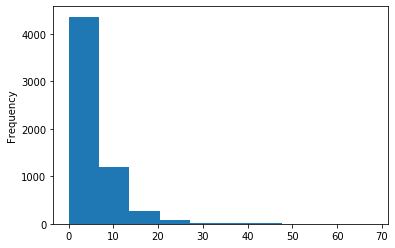

In [0]:
data['# Inclusion Criteria'].plot.hist()
plt.show()

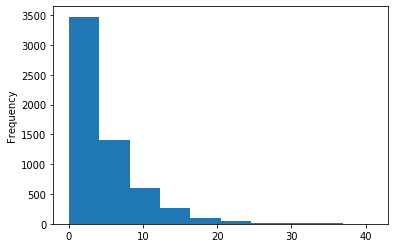

In [0]:
data['# Exclusion Criteria'].plot.hist()
plt.show()

The distributions for both Inclusion and Exclusion Criteria are remarkably similar. This does not bode well for any successive quantitative analysis, as there seeems to be no correlation between inclusion and exclusion criteria. 

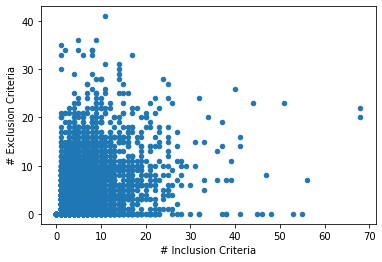

In [0]:
data.plot.scatter('# Inclusion Criteria', '# Exclusion Criteria');

The scatterplot confirms our worst fears -- there is no obvious relationship between Inclusion and Exclusion Criteria. If there were a simple negative correlation, which is easy to intuit, then the next analyses we would conduct would find the differences between each criteria. Unfortunately, the commonality of eligibility criteria are that studies tend to contain both. Not particularly useful.

In [15]:
import itertools

data.sort_values('numWordsInclusion', ascending=False).InclusionCriteria.iloc[0]

g = data.groupby('Status')
incs = g['bagInclusion'].aggregate(lambda listofbags: list(itertools.chain.from_iterable(listofbags)))
TF = incs.apply(lambda bag: pandas.Series(bag).value_counts())
IDF = numpy.log(len(TF)/TF.count())
TFIDF = TF * IDF
#g['bagInclusion']
TFIDF

,',",",,e,t,a,i,o,n,r,s,l,c,d,h,u,m,p,f,g,y,b,v,w,-,1,],[,k,0,j,x,2,8,5,/,q,3,6,4,...,~,×,*,μ,†,•,ï,ﬁ,#,^,°,±,º,\,µ,·,€,β,½,—,²,’,ã,δ,$,γ,⁰,§,α,¢,_,˚,ö,˃,ß,¾,‐,ü,₂,⁄
Status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Active, not recruiting",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.575247,26.414094,0.0,0.0,22.972257,37.253061,17.689438,15.768413,13.447175,52.584644,35.419176,10.245467,19.378274,19.044166,29.785707,17.578406,...,5.733069,5.615407,2.319570,3.743604,1.871802,0.773190,1.466337,2.564949,0.619039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Approved for marketing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160085,0.320171,0.0,0.0,0.160085,0.167054,0.160085,NaN,0.160085,NaN,NaN,0.320171,0.334108,NaN,NaN,0.262364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Available,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240128,0.160085,0.0,0.0,0.320171,NaN,0.080043,0.240128,0.160085,NaN,NaN,0.400214,NaN,0.501162,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Completed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.908264,215.394926,0.0,0.0,183.057672,324.084924,147.118497,134.391706,122.225215,453.036929,301.718904,74.599804,159.202543,149.680460,277.632209,205.955948,...,2.866534,NaN,19.329747,18.718022,1.871802,5.412329,5.865348,NaN,11.761745,40.237549,15.463798,12.965205,14.974417,7.071930,11.230813,7.487209,7.694848,5.615407,4.399011,3.743604,3.743604,3.743604,2.564949,1.871802,2.564949,2.564949,2.564949,2.564949,2.564949,2.564949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Enrolling by invitation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.164356,9.845253,0.0,0.0,7.924228,12.529056,4.962648,4.882605,4.562434,22.798936,14.692399,2.321239,6.682163,5.178677,12.134918,5.509650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.619039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
No longer available,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.320171,0.320171,0.0,0.0,0.240128,0.668216,0.320171,0.400214,0.080043,NaN,0.262364,0.480256,0.167054,0.334108,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Not yet recruiting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.408755,16.168627,0.0,0.0,14.327645,17.206571,11.125936,10.485595,9.525082,33.830680,27.548248,4.242264,7.517434,11.025570,17.283065,15.217127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.857118,0.773190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recruiting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.736417,95.731078,0.0,0.0,91.008559,131.471565,62.593397,70.837796,59.231604,210.338574,157.156194,38.260414,63.814660,83.694096,143.780389,94.188771,...,2.866534,NaN,4.639139,NaN,NaN,7.731899,NaN,NaN,4.952314,17.952137,3.092760,NaN,1.871802,1.178655,3.743604,NaN,NaN,11.230813,NaN,1.871802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.129899,2.564949,2.564949,2.564949,2.564949,2.564949,1.871802,NaN,NaN,NaN
Suspended,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.120598,1.600854,0.0,0.0,0.880470,3.0069

Cannot continue with text analysis yet -- noted below.

**Part 5: Analyze Data**

Once our preliminary visualizations have been produced, we were able to then analyze some of these findings.
In terms of inclusion criteria, it seems that most of the trials listed under 10 inclusion criteria on their information page.
In terms of exclusion criteria, it seems that most of the trials listed under 10 exclusuion criteria on their information page.
As this is initial analysis on high-level visualizations of our data, we cannot tell much in terms of the similarity between inclusion/ exclusion criteria of trials other than there is not a high variation in terms of number of inclusion or exclusion criteria listed.

Since the raw Eligibility Criteria are both as present in the typical study, the next step in analysis would be an inter-criterion text analysis to determine commonalities present across studies. There are some issues with the current CleanedInclusionCriteria bag of words, so for now we can say that inter-criterion analysis by different variables will be the next step in analysis. The first step, a rudimentary Vector Space Model, was created to analyze criterion by location the study was conducted. This is a promising next step, though currently there are difficulties with how the bag of words is structured.


The current bag of words vector space model is not functioning properly within Google Colab. In the attached separate notebook, it shows that between studies by study status, the least related frequency variables are the specific treatments. To answer the client's question so far, there are no particular similarities between treatment outcome measures between studies so far, which is evidence contrary to the hypothesis.